In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
import random as rn
import tensorflow as tf
import cv2                  
from tqdm import tqdm
import time
import os                   
print(os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images'))
print(os.listdir('../input/resnet50'))

Using TensorFlow backend.


['Parasitized', 'Uninfected']
['resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'imagenet_class_index.json', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5']


In [2]:
X=[]
Y=[]
IMG_SIZE=50
parasitized_dir='../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized'
uninfected_dir='../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected'

In [3]:
categories = ['Parasitized','Uninfected']
print("labels of images are " ,categories )

labels of images are  ['Parasitized', 'Uninfected']


In [4]:
def assign_label(cell_type):
    return cell_type

In [5]:
def build_train_data(cell_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            label=assign_label(cell_type)
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            X.append(np.array(img))
            Y.append(str(label))
        except:
            print("")

In [6]:
build_train_data('Parasitized',parasitized_dir)
print(len(X))

 47%|████▋     | 6501/13780 [00:11<00:12, 585.51it/s]

100%|██████████| 13780/13780 [00:23<00:00, 586.20it/s]

13779


In [7]:
build_train_data('Uninfected',uninfected_dir)
print(len(X))

 47%|████▋     | 6495/13780 [00:10<00:11, 632.22it/s]

100%|██████████| 13780/13780 [00:23<00:00, 592.30it/s]

27558


In [8]:
def find_categories_count(Y):
    categories_count={
    'Parasitized':0,
    'Uninfected':0
    }
    for i in Y:
         categories_count[i]=categories_count[i]+1
    return categories_count

In [9]:
def find_class_label(data):
    match={
    0:'Parasitized',
    1:'Uninfected'
        }
    return match[data]

In [10]:
print(find_categories_count(Y))

{'Parasitized': 13779, 'Uninfected': 13779}


In [11]:
height=[]
categories_count=find_categories_count(Y)
for i in categories_count:
    height.append(categories_count[i])

## Total dataset

<BarContainer object of 2 artists>

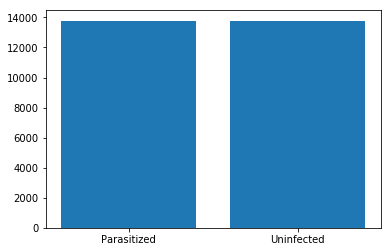

In [12]:
plt.bar([x for x in categories],height)

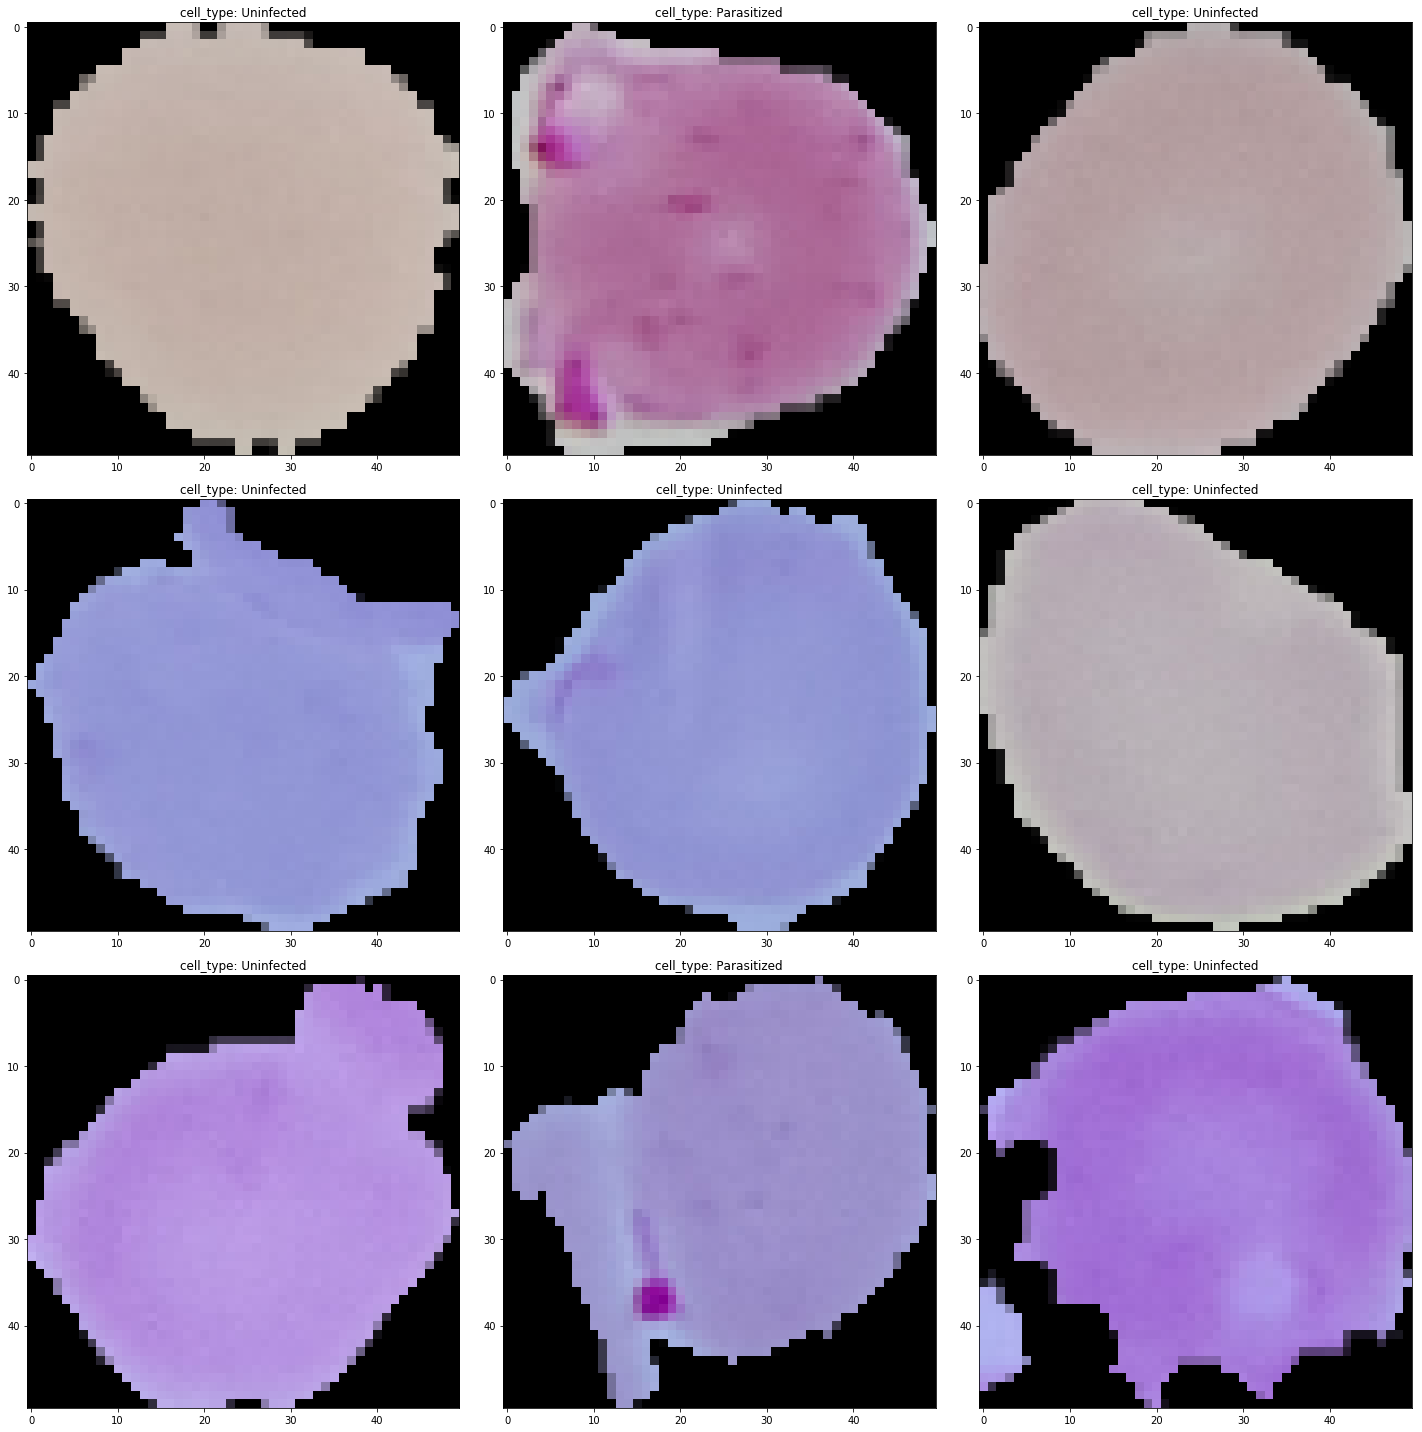

In [13]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches(20,20)
for i in range(3):
    for j in range (3):
        l=rn.randint(0,len(Y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('cell_type: '+Y[l])
        
plt.tight_layout()

In [14]:
def covert_categories_to_numeric(data):
    y=[]
    match={
    'Parasitized':0,
    'Uninfected':1
    }
    for i in  data:
        y.append(match[i])
    return np.array(y)

In [15]:
Y=covert_categories_to_numeric(Y)
print(Y)

[0 0 0 ... 1 1 1]


## One hot encoding:-

In [16]:
Y=to_categorical(Y,2)

## normalization:-

In [17]:
X=np.array(X)
X=X/255

 ## train,validation and testing split

In [18]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=48)
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.1,random_state=48)

## printing statistics about the dataset

In [19]:

print('There are %d total image categories.' % len(categories))
print('There are %s total cell images.\n' % X.shape[0])
print('There are %d training cell images.' % x_train.shape[0])
print('There are %d validation cell images.' % x_valid.shape[0])
print('There are %d testing cell images.'% x_test.shape[0])

There are 2 total image categories.
There are 27558 total cell images.

There are 22321 training cell images.
There are 2481 validation cell images.
There are 2756 testing cell images.


<BarContainer object of 4 artists>

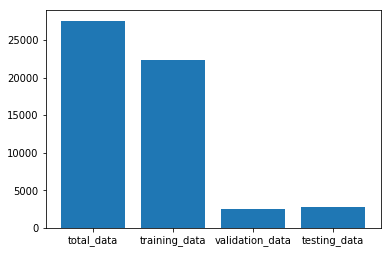

In [20]:
plt.bar(['total_data','training_data','validation_data','testing_data'],[X.shape[0],x_train.shape[0],x_valid.shape[0],x_test.shape[0]])

 ## Training categories

<BarContainer object of 2 artists>

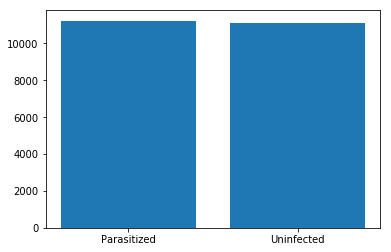

In [21]:
height=[]
data=[]
for i in np.argmax(y_train,axis=1):
    data.append(find_class_label(i))
categories_count=find_categories_count(data)
for i in categories_count:
    height.append(categories_count[i])
plt.bar([x for x in categories],height)

In [22]:
y_train.shape[0]

22321

## validation categories

<BarContainer object of 2 artists>

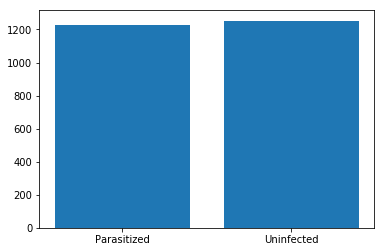

In [23]:
height=[]
data=[]
for i in np.argmax(y_valid,axis=1):
    data.append(find_class_label(i))
categories_count=find_categories_count(data)
for i in categories_count:
    height.append(categories_count[i])
plt.bar([x for x in categories],height)

In [24]:
y_valid.shape[0]

2481

## Testing categories

<BarContainer object of 2 artists>

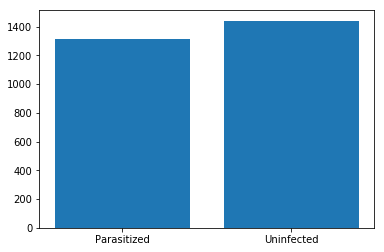

In [25]:
height=[]
data=[]
for i in np.argmax(y_test,axis=1):
    data.append(find_class_label(i))
categories_count=find_categories_count(data)
for i in categories_count:
    height.append(categories_count[i])
plt.bar([x for x in categories],height)

In [26]:
y_test.shape[0]

2756

In [27]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

## funtion to plot the confusion matrix

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## benchmark model

In [29]:
benchmark_checkpoints = ModelCheckpoint(filepath='weights.best.from_bench.hdf5', 
                               verbose=1, save_best_only=True)

In [30]:
bench_model = Sequential()
bench_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(50,50, 3)))
bench_model.add(MaxPooling2D(pool_size=2))
bench_model.add(Flatten())
bench_model.add(Dense(2, activation='softmax'))

In [31]:
bench_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 20002     
Total params: 20,210
Trainable params: 20,210
Non-trainable params: 0
_________________________________________________________________


In [32]:
bench_model.compile(loss='categorical_crossentropy', 
                    optimizer=Adam(lr=0.1, decay=1e-6), 
                  metrics=['accuracy'])

In [33]:
t0=time.time()
bench_results = bench_model.fit(x_train, y_train, batch_size=32,
                   epochs=10,validation_data=(x_valid,y_valid), callbacks=[benchmark_checkpoints], verbose=1)
t1=time.time()

Train on 22321 samples, validate on 2481 samples
Epoch 1/10
22321/22321 [==============================] - 9s 415us/step - loss: 8.1059 - acc: 0.4966 - val_loss: 7.9778 - val_acc: 0.5050

Epoch 00001: val_loss improved from inf to 7.97784, saving model to weights.best.from_bench.hdf5
Epoch 2/10
22321/22321 [==============================] - 5s 219us/step - loss: 8.1136 - acc: 0.4966 - val_loss: 7.9778 - val_acc: 0.5050

Epoch 00002: val_loss did not improve from 7.97784
Epoch 3/10
22321/22321 [==============================] - 5s 220us/step - loss: 8.1136 - acc: 0.4966 - val_loss: 7.9778 - val_acc: 0.5050

Epoch 00003: val_loss did not improve from 7.97784
Epoch 4/10
22321/22321 [==============================] - 5s 219us/step - loss: 8.1136 - acc: 0.4966 - val_loss: 7.9778 - val_acc: 0.5050

Epoch 00004: val_loss did not improve from 7.97784
Epoch 5/10
22321/22321 [==============================] - 5s 218us/step - loss: 8.1136 - acc: 0.4966 - val_loss: 7.9778 - val_acc: 0.5050

Epoch 

In [34]:
pred=bench_model.predict(x_test)
bench_pred=np.argmax(pred ,axis=1)

In [35]:
print('total training time is around: ',int(t1-t0),'seconds')

total training time is around:  53 seconds


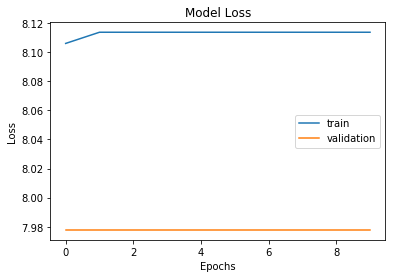

In [36]:
plt.plot(bench_results.history['loss'])
plt.plot(bench_results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

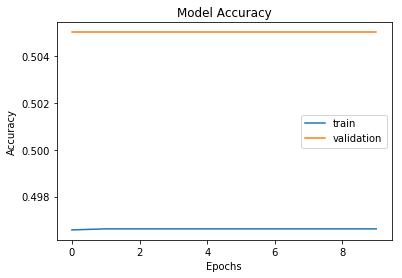

In [37]:
plt.plot(bench_results.history['acc'])
plt.plot(bench_results.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [38]:
mis_classification_count=0
for i in range(0,len(bench_pred)):
    if bench_pred[i]!=np.argmax(y_test[i]):
        mis_classification_count+=1
        
print(mis_classification_count)

1315


In [39]:
test_accuracy = 100*(y_test.shape[0]-mis_classification_count)/len(bench_pred)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 52.2859%


Confusion matrix
[[   0 1315]
 [   0 1441]]


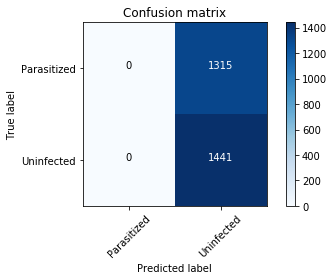

In [40]:
plot_confusion_matrix(confusion_matrix(np.argmax(y_test ,axis=1), bench_pred), classes=categories,
                      title='Confusion matrix')

In [41]:
print(classification_report( np.argmax(y_test ,axis=1),bench_pred ,target_names =categories ))

              precision    recall  f1-score   support

 Parasitized       0.00      0.00      0.00      1315
  Uninfected       0.52      1.00      0.69      1441

   micro avg       0.52      0.52      0.52      2756
   macro avg       0.26      0.50      0.34      2756
weighted avg       0.27      0.52      0.36      2756



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Creating Sequential Model:

In [42]:
sequential_Checkpoints=ModelCheckpoint(filepath='weights.best.from_sequential_model.hdf5', 
                               verbose=1, save_best_only=True)

In [43]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
__________

In [44]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

In [45]:
t0=time.time()
sequential_results = model.fit(x_train, y_train, batch_size=32,
                     epochs=10,validation_data=(x_valid,y_valid),callbacks=[sequential_Checkpoints], verbose=1)
t1=time.time()

Train on 22321 samples, validate on 2481 samples
Epoch 1/10
22321/22321 [==============================] - 8s 375us/step - loss: 0.3948 - acc: 0.8126 - val_loss: 0.1770 - val_acc: 0.9383

Epoch 00001: val_loss improved from inf to 0.17695, saving model to weights.best.from_sequential_model.hdf5
Epoch 2/10
22321/22321 [==============================] - 8s 345us/step - loss: 0.1591 - acc: 0.9498 - val_loss: 0.1445 - val_acc: 0.9553

Epoch 00002: val_loss improved from 0.17695 to 0.14451, saving model to weights.best.from_sequential_model.hdf5
Epoch 3/10
22321/22321 [==============================] - 8s 341us/step - loss: 0.1407 - acc: 0.9555 - val_loss: 0.1434 - val_acc: 0.9532

Epoch 00003: val_loss improved from 0.14451 to 0.14340, saving model to weights.best.from_sequential_model.hdf5
Epoch 4/10
22321/22321 [==============================] - 8s 345us/step - loss: 0.1307 - acc: 0.9572 - val_loss: 0.1370 - val_acc: 0.9553

Epoch 00004: val_loss improved from 0.14340 to 0.13697, saving 

In [46]:
print('total training time is around: ',int(t1-t0),'seconds')

total training time is around:  78 seconds


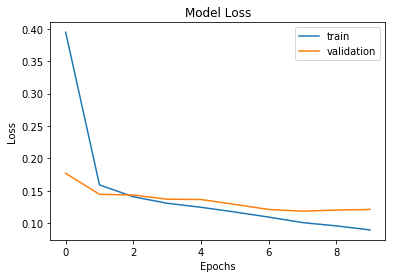

In [47]:
plt.plot(sequential_results.history['loss'])
plt.plot(sequential_results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

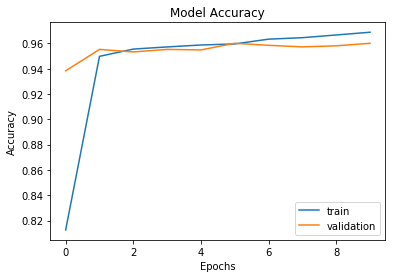

In [48]:
plt.plot(sequential_results.history['acc'])
plt.plot(sequential_results.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [49]:
model.load_weights('weights.best.from_sequential_model.hdf5')

In [50]:
pred=model.predict(x_test)
sequential_model_pred=np.argmax(pred,axis=1)

In [51]:
mis_classification_count=0
mis_classification_index=[]
for i in range(0,len(sequential_model_pred)):
    if sequential_model_pred[i]!=np.argmax(y_test[i]):
        mis_classification_count+=1
        mis_classification_index.append(i)
print(mis_classification_count)     

105


In [52]:
test_accuracy = 100*(y_test.shape[0]-mis_classification_count)/len(sequential_model_pred)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 96.1901%


Confusion matrix
[[1255   60]
 [  45 1396]]


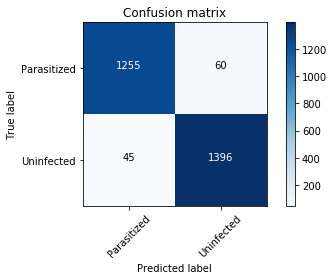

In [53]:
plot_confusion_matrix(confusion_matrix(np.argmax(y_test ,axis=1), sequential_model_pred), classes=categories,
                      title='Confusion matrix')

In [54]:
print(classification_report(np.argmax(y_test ,axis=1), sequential_model_pred ,target_names =categories ))

              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      1315
  Uninfected       0.96      0.97      0.96      1441

   micro avg       0.96      0.96      0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



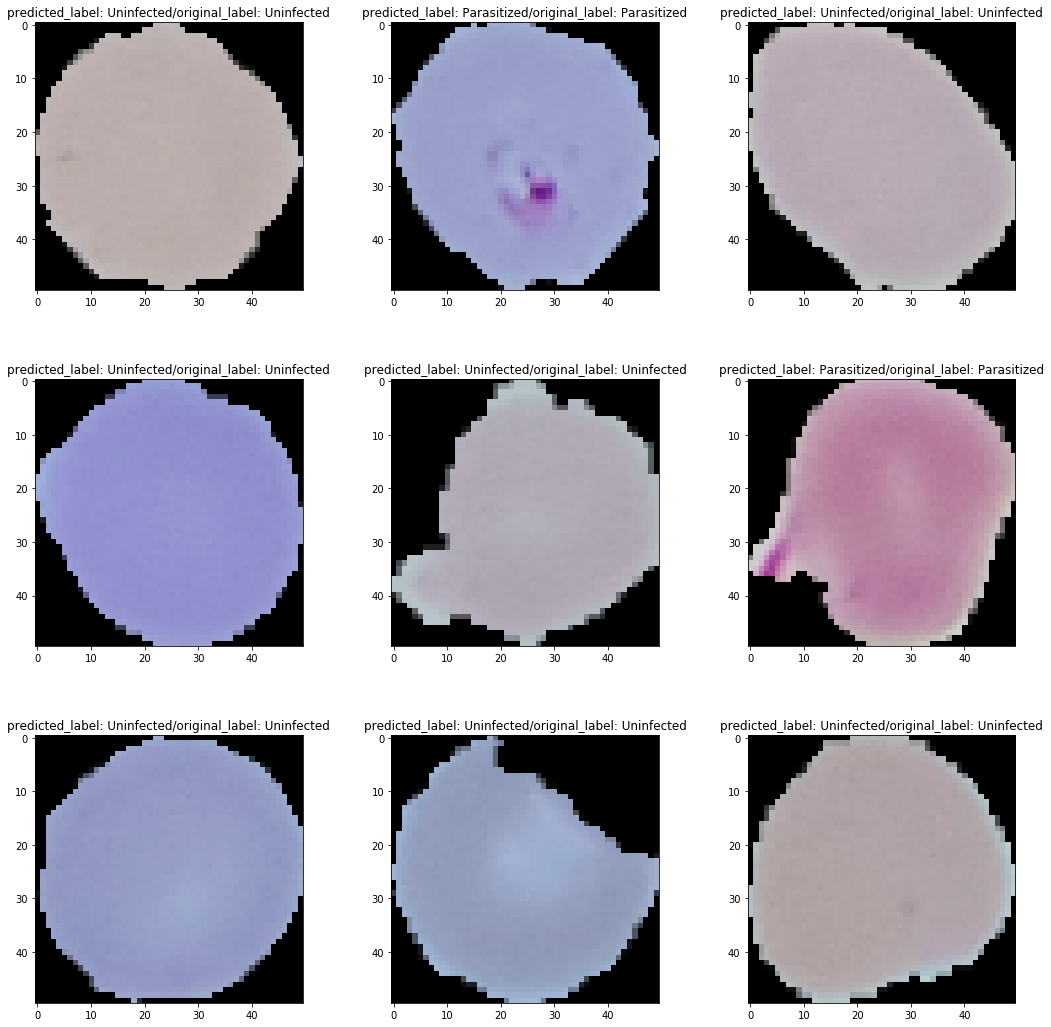

In [55]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (3):
        l= rn.randint(0,len(y_test))
        ax[i,j].imshow(x_test[l])
        ax[i,j].set_title('predicted_label: '+find_class_label(sequential_model_pred[l])+'/original_label: '+find_class_label(np.argmax(y_test[l])))
        
plt.tight_layout()

In [56]:
resnet50_checkpoints = ModelCheckpoint(filepath='weights.best.from_resnet50.hdf5', 
                               verbose=1, save_best_only=True)

## resnet50 model

In [57]:
model = Sequential()
model.add(ResNet50(include_top = False, weights = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape = (50,50,3)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 27,783,554
Trainable params: 27,730,434
Non-trainable params: 53,120
_________________________________________________________________


In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [59]:
t0=time.time()
resnet50_results = model.fit(x_train, y_train, batch_size=32,
                     epochs=10,validation_data=(x_valid,y_valid),callbacks=[resnet50_checkpoints ], verbose=1)
t1=time.time()

Train on 22321 samples, validate on 2481 samples
Epoch 1/10
22321/22321 [==============================] - 204s 9ms/step - loss: 0.7528 - acc: 0.7365 - val_loss: 1.1491 - val_acc: 0.4954

Epoch 00001: val_loss improved from inf to 1.14906, saving model to weights.best.from_resnet50.hdf5
Epoch 2/10
22321/22321 [==============================] - 197s 9ms/step - loss: 0.2096 - acc: 0.9248 - val_loss: 0.1732 - val_acc: 0.9420

Epoch 00002: val_loss improved from 1.14906 to 0.17321, saving model to weights.best.from_resnet50.hdf5
Epoch 3/10
22321/22321 [==============================] - 187s 8ms/step - loss: 0.1430 - acc: 0.9502 - val_loss: 0.1429 - val_acc: 0.9468

Epoch 00003: val_loss improved from 0.17321 to 0.14293, saving model to weights.best.from_resnet50.hdf5
Epoch 4/10
22321/22321 [==============================] - 187s 8ms/step - loss: 0.1808 - acc: 0.9355 - val_loss: 1.7527 - val_acc: 0.7412

Epoch 00004: val_loss did not improve from 0.14293
Epoch 5/10
22321/22321 [============

In [60]:
print('total training time is around: ',int(t1-t0),'seconds')

total training time is around:  1911 seconds


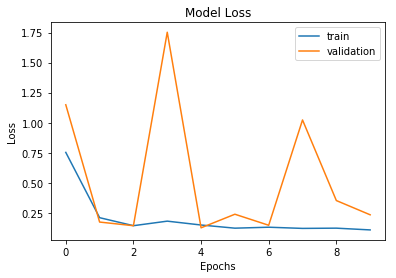

In [61]:
plt.plot(resnet50_results.history['loss'])
plt.plot(resnet50_results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

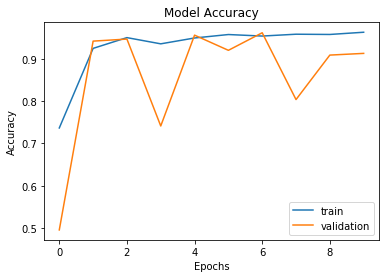

In [62]:
plt.plot(resnet50_results.history['acc'])
plt.plot(resnet50_results.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [63]:
model.load_weights('weights.best.from_resnet50.hdf5')

In [64]:
resnet50_pred=np.argmax(model.predict(x_test),axis=1)

In [65]:
mis_classification_count=0
mis_classification_index=[]
for i in range(0,len(resnet50_pred)):
    if resnet50_pred[i]!=np.argmax(y_test[i]):
        mis_classification_count+=1
        mis_classification_index.append(i)
print(mis_classification_count)     

121


In [66]:
test_accuracy = 100*(y_test.shape[0]-mis_classification_count)/len(resnet50_pred)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 95.6096%


Confusion matrix
[[1244   71]
 [  50 1391]]


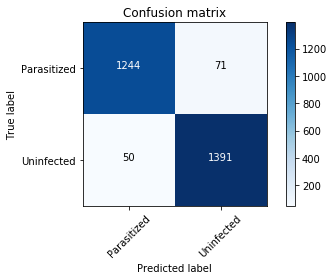

In [67]:
plot_confusion_matrix(confusion_matrix(np.argmax(y_test ,axis=1), resnet50_pred), classes=categories,
                      title='Confusion matrix')

In [68]:
print(classification_report(np.argmax(y_test ,axis=1), resnet50_pred ,target_names =categories ))

              precision    recall  f1-score   support

 Parasitized       0.96      0.95      0.95      1315
  Uninfected       0.95      0.97      0.96      1441

   micro avg       0.96      0.96      0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



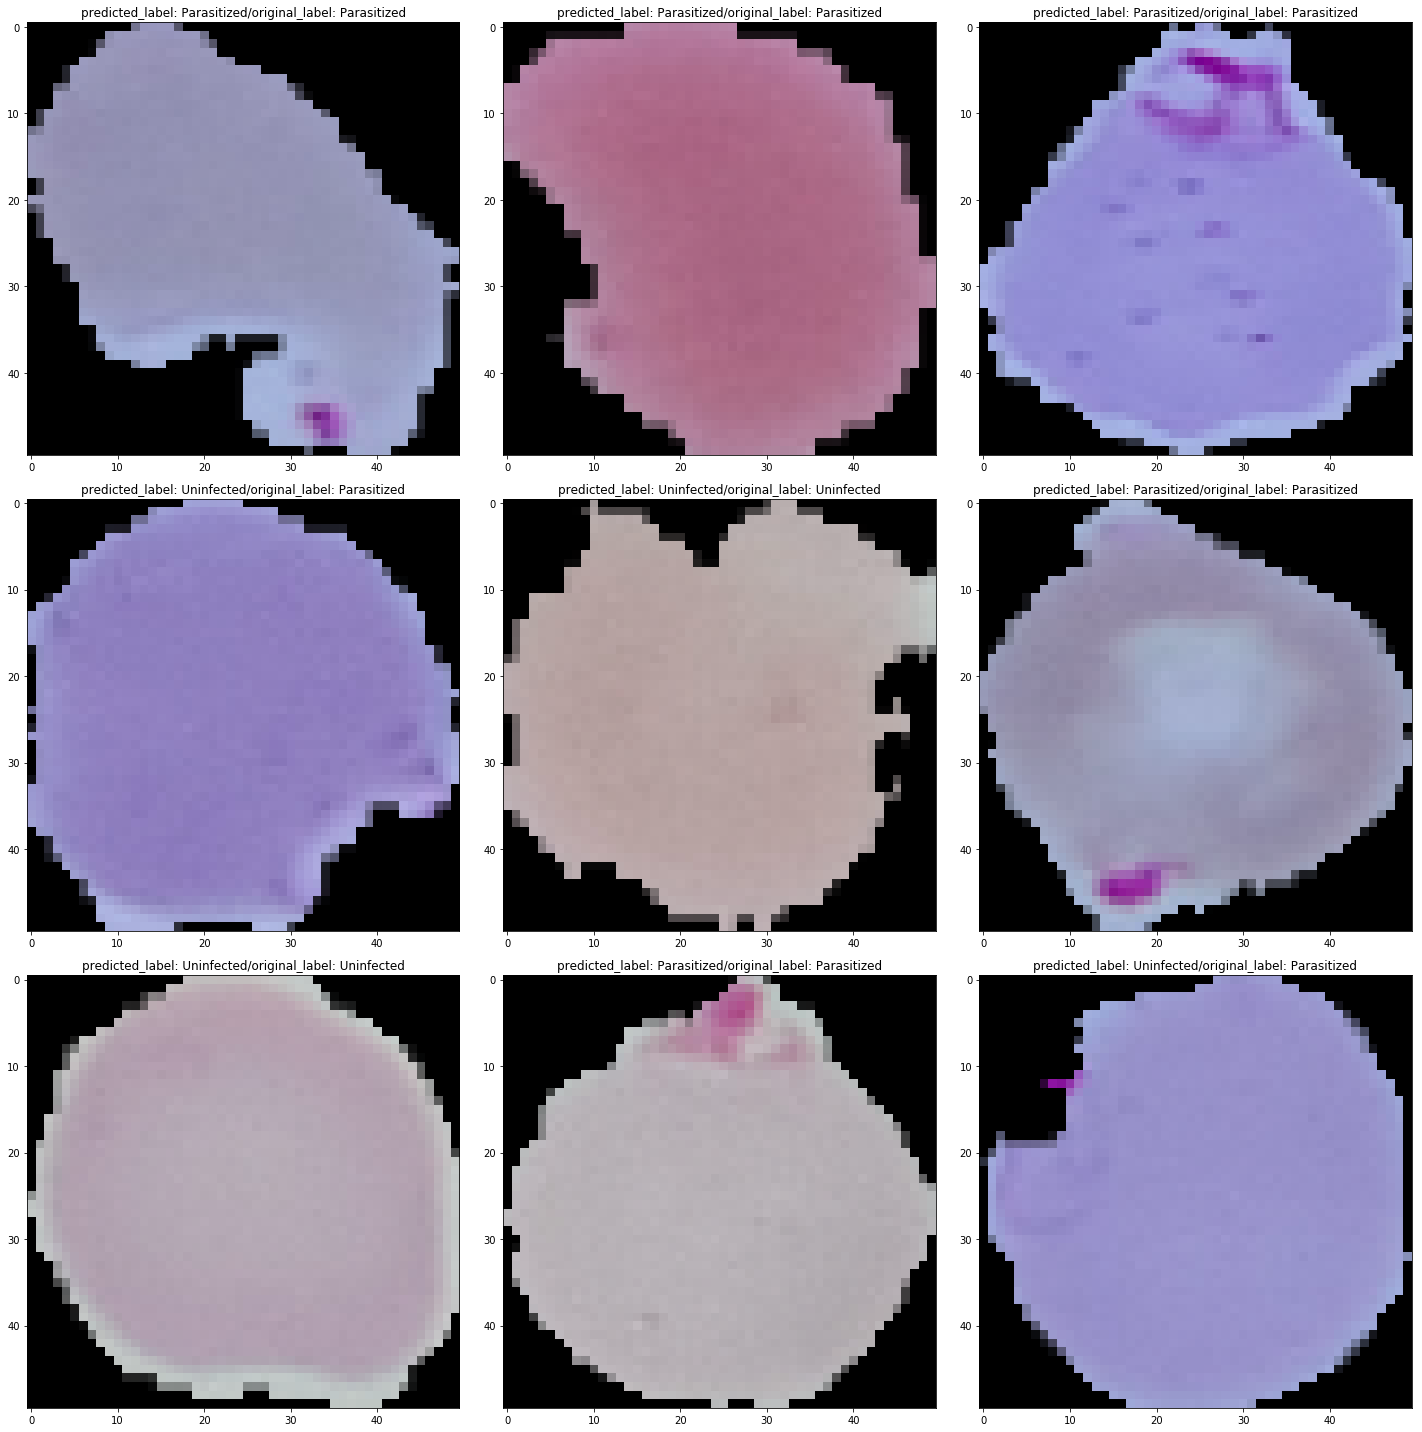

In [69]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches(20,20)
for i in range(3):
    for j in range (3):
        l= rn.randint(0,len(y_test))
        ax[i,j].imshow(x_test[l])
        ax[i,j].set_title('predicted_label: '+find_class_label(resnet50_pred[l])+'/original_label: '+find_class_label(np.argmax(y_test[l])))
        
plt.tight_layout()